<a href="https://colab.research.google.com/github/fourerr/neural_network/blob/main/NN_project_with_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### written by Zafrir Fourrer & Amihay Hassan
general guidlines by Osher Zakin

In [ ]:
from sklearn.model_selection import train_test_split
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers
from keras.preprocessing.image import load_img, img_to_array
import random
import shutil
import os.path
from os import path
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# make directory and download the file to this directory

!mkdir '/tmp/weather'

!wget --no-check-certificate \
  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip -O \
  /tmp/weather/weather.zip

--2021-06-07 19:08:20--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.96.11
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.96.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘/tmp/weather/weather.zip’

/tmp/weather/weathe 100%[===================>]  91.16M  18.0MB/s    in 6.0s    

2021-06-07 19:08:27 (15.3 MB/s) - ‘/tmp/weather/weather.zip’ saved [95592747/95592747]



In [ ]:
# extract the files from the downloaded zip

import os
import zipfile

local_zip = '/tmp/weather/weather.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/weather')
zip_ref.close()

local_zip = '/tmp/weather/dataset2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/weather')
zip_ref.close()

In [ ]:
# get the list of files from the new folder
list_for_df = os.listdir('/tmp/weather/dataset2')

In [ ]:
# create new dataframe contains the pictures
df = pd.DataFrame(list_for_df,columns =['filename'])

In [ ]:
# function to extract tag name from full file name
def tag_name(file_name):
  name = ''
  for char in file_name.split(".")[0]:
    if char.isalpha():
      name += char
  return(name)

In [ ]:
# get list of all tags of the pictures
tag = []

for file in list_for_df:
  tag.append(tag_name(file))

In [ ]:
# add the tags list as a column to the dataframe
df['class'] = tag

In [ ]:
# show the dataframe
df

,filename,class
0,shine165.jpg,shine
1,sunrise115.jpg,sunrise
2,rain34.jpg,rain
3,shine159.jpg,shine
4,rain153.jpg,rain
...,...,...
1120,shine204.jpg,shine
1121,sunrise288.jpg,sunrise
1122,sunrise353.jpg,sunrise
1123,shine94.jpg,shine


In [ ]:
# split the data from the dataframe to train and test.
# 80/20 because this is very common split as we have seen in other models built by professionals
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [ ]:
# show the trian dataframe
train

,filename,class
1016,sunrise314.jpg,sunrise
916,shine60.jpg,shine
938,shine206.jpg,shine
483,rain214.jpg,rain
923,rain176.jpg,rain
...,...,...
852,shine6.jpg,shine
673,cloudy45.jpg,cloudy
375,cloudy111.jpg,cloudy
1071,rain115.jpg,rain


In [ ]:
SIZE = 224 #change to fit to vgg model below

# adding only rescale for the model without the augmentation

train_datagen_no_aug = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = train_datagen_no_aug.flow_from_dataframe(train,
                                                    x_col="filename", 
                                                    y_col="class",
                                                    target_size = (SIZE, SIZE),
                                                    directory = '/tmp/weather/dataset2')
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator

#adding augementation

train_datagen = ImageDataGenerator(rescale=1./255,
     rotation_range=15,
     width_shift_range=0.1,
     height_shift_range=0.1,
     shear_range=0.1,
     zoom_range=0.1,
     horizontal_flip=True,)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train,
                                                    x_col="filename", 
                                                    y_col="class",
                                                    target_size = (SIZE, SIZE),
                                                    directory = '/tmp/weather/dataset2')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow validation images in batches of 32 using val_datagen generator
test_generator = test_datagen.flow_from_dataframe(test,
                                                  x_col="filename", 
                                                  y_col="class",
                                                  target_size = (SIZE, SIZE),
                                                  directory = '/tmp/weather/dataset2')

Found 900 validated image filenames belonging to 4 classes.
Found 900 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.


## CNN model, inspired by Intel's suggestion in EX4

In [ ]:
# Let's build a CNN using Keras' Sequential capabilities
num_classes = 4

# model suggested by Intel -the best model 
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape = (SIZE, SIZE, 3)))
model.add(Conv2D(32, (3, 3), strides = (1,1), padding='same')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), strides = (1,1), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), strides = (1,1), padding='same')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# model result without augmentation
history_no_aug = model.fit(train_generator_no_aug, steps_per_epoch=len(train_generator_no_aug),
		validation_data=test_generator, validation_steps=len(test_generator), epochs=10, verbose=1)

Epoch 1/10
29/29 [==============================] - 53s 289ms/step - loss: 1.1917 - accuracy: 0.5039 - val_loss: 0.4836 - val_accuracy: 0.8089
Epoch 2/10
29/29 [==============================] - 7s 255ms/step - loss: 0.4487 - accuracy: 0.8462 - val_loss: 0.3181 - val_accuracy: 0.8978
Epoch 3/10
29/29 [==============================] - 7s 262ms/step - loss: 0.3163 - accuracy: 0.8855 - val_loss: 0.2946 - val_accuracy: 0.8978
Epoch 4/10
29/29 [==============================] - 7s 254ms/step - loss: 0.3127 - accuracy: 0.8613 - val_loss: 0.2367 - val_accuracy: 0.9200
Epoch 5/10
29/29 [==============================] - 7s 254ms/step - loss: 0.2211 - accuracy: 0.9197 - val_loss: 0.6146 - val_accuracy: 0.7911
Epoch 6/10
29/29 [==============================] - 7s 256ms/step - loss: 0.3129 - accuracy: 0.8754 - val_loss: 0.3217 - val_accuracy: 0.8578
Epoch 7/10
29/29 [==============================] - 7s 258ms/step - loss: 0.2010 - accuracy: 0.9300 - val_loss: 0.2559 - val_accuracy: 0.8889
Epoch

In [ ]:
# recompile the model to make sure the model is reset (we don't want any influence from previous trainings)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# model result with augmentation
history = model.fit(train_generator, steps_per_epoch=len(train_generator),
		validation_data=test_generator, validation_steps=len(test_generator), epochs=10, verbose=1)

Epoch 1/10
29/29 [==============================] - 65s 670ms/step - loss: 1.0651 - accuracy: 0.5574 - val_loss: 0.5938 - val_accuracy: 0.7156
Epoch 2/10
29/29 [==============================] - 19s 642ms/step - loss: 0.5496 - accuracy: 0.7618 - val_loss: 0.4284 - val_accuracy: 0.8267
Epoch 3/10
29/29 [==============================] - 19s 644ms/step - loss: 0.4845 - accuracy: 0.8143 - val_loss: 0.4164 - val_accuracy: 0.8444
Epoch 4/10
29/29 [==============================] - 19s 670ms/step - loss: 0.4286 - accuracy: 0.8433 - val_loss: 0.3431 - val_accuracy: 0.8622
Epoch 5/10
29/29 [==============================] - 19s 666ms/step - loss: 0.4621 - accuracy: 0.8192 - val_loss: 0.4005 - val_accuracy: 0.8667
Epoch 6/10
29/29 [==============================] - 19s 666ms/step - loss: 0.4147 - accuracy: 0.8535 - val_loss: 0.3770 - val_accuracy: 0.9022
Epoch 7/10
29/29 [==============================] - 19s 653ms/step - loss: 0.3389 - accuracy: 0.8901 - val_loss: 0.2972 - val_accuracy: 0.9111

# display the Intel model results


validation accuracy is 0.884


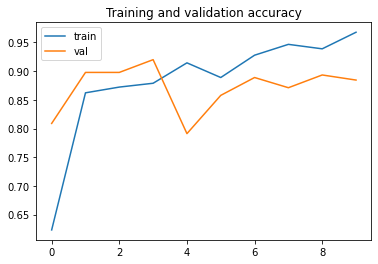

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history_no_aug.history['accuracy']
# print(history.history, end="\n")
val_acc = history_no_aug.history['val_accuracy']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'])

print(f"validation accuracy is {round(history_no_aug.history['val_accuracy'][-1], 3)}")

validation accuracy is 0.907


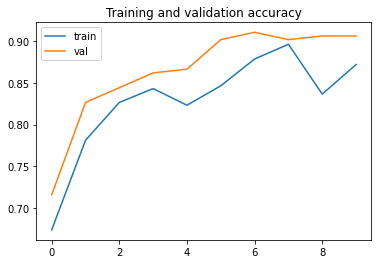

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
# print(history.history, end="\n")
val_acc = history.history['val_accuracy']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'])

print(f"validation accuracy is {round(history.history['val_accuracy'][-1], 3)}")

###As we can see, adding the augmentation, has slightly improved our model abilities.
#####notice that the difference is not very big and can be subjected to the margin of error.

# model with vgg 

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [ ]:
# define cnn model
def define_model():
	# load model
  model = VGG16(include_top=False, input_shape=(SIZE, SIZE, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
	# add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(4, activation='softmax')(class1)
	# define new model
  model = Model(inputs=model.inputs, outputs=output)
	# compile model
  opt = Adam(learning_rate=0.003)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model_vgg = define_model()

In [ ]:
model_vgg.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
history_vgg = model_vgg.fit(train_generator, steps_per_epoch=len(train_generator),
		validation_data=test_generator, validation_steps=len(test_generator), epochs=10, verbose=1)

Epoch 1/10
29/29 [==============================] - 21s 719ms/step - loss: 0.0761 - accuracy: 0.9522 - val_loss: 0.1151 - val_accuracy: 0.9378
Epoch 2/10
29/29 [==============================] - 21s 713ms/step - loss: 0.0688 - accuracy: 0.9589 - val_loss: 0.0841 - val_accuracy: 0.9289
Epoch 3/10
29/29 [==============================] - 21s 711ms/step - loss: 0.0626 - accuracy: 0.9689 - val_loss: 0.1028 - val_accuracy: 0.9289
Epoch 4/10
29/29 [==============================] - 21s 709ms/step - loss: 0.0752 - accuracy: 0.9544 - val_loss: 0.1201 - val_accuracy: 0.9200
Epoch 5/10
29/29 [==============================] - 21s 732ms/step - loss: 0.0837 - accuracy: 0.9489 - val_loss: 0.0899 - val_accuracy: 0.9378
Epoch 6/10
29/29 [==============================] - 21s 716ms/step - loss: 0.0552 - accuracy: 0.9689 - val_loss: 0.0883 - val_accuracy: 0.9511
Epoch 7/10
29/29 [==============================] - 21s 703ms/step - loss: 0.0546 - accuracy: 0.9689 - val_loss: 0.0784 - val_accuracy: 0.9511

# display the vgg model result

validation accuracy is 0.951


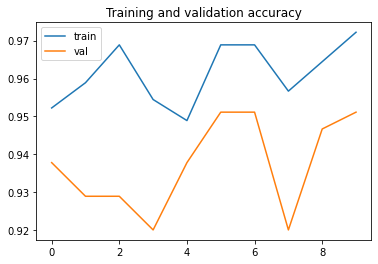

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history_vgg.history['accuracy']
# print(history.history, end="\n")
val_acc = history_vgg.history['val_accuracy']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'])

print(f"validation accuracy is {round(history_vgg.history['val_accuracy'][-1], 3)}")